The purpose of this notebook is to get the head position and direction of the ferret for each stimulus presentation.

The input data consists of two sources:
(1) Stimulus metadata after temporal alignment to both video and neural recording systems
(2) LED tracking data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [2]:
data_dir = Path('/home/stephen/Github/Speaker_Grid/data/F1901_Crumble_Squid/2021-05-27_Squid_15-57')

stim_file = '2021-05-27T17-57-07_Stim_LED_MCS.csv'

stim = pd.read_csv( str(data_dir / stim_file))

print(stim.shape)

spike_file = data_dir / 'spike_times' / '2021-05-27T17-56-11_SpikeTimes_2_C13.txt'
spikes = np.loadtxt( spike_file, delimiter=',')

print(spikes[0])

(553, 28)
0.00535


### Get peri-stimulus histogram

In [3]:
bin_width = 0.01
bin_edges = np.arange(-0.1, 0.41, bin_width)
spike_count = np.zeros((stim.shape[0], len(bin_edges)-1), dtype=np.int64)

for idx, row  in stim.iterrows():

    t_delta = spikes - row['MCS_Time']

    spike_count[idx], _ = np.histogram(t_delta, bins=bin_edges)

spike_rate = spike_count / bin_width


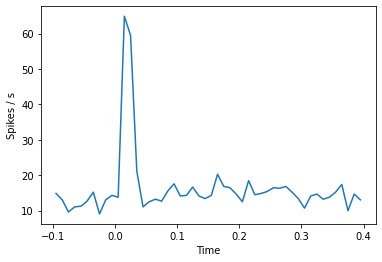

In [4]:
mean_sr = np.mean(spike_rate, axis=0)
bin_centers = bin_edges[0:-1] + (bin_width/2)


fig, ax = plt.subplots(1,1)
ax.plot(bin_centers, mean_sr)
ax.set_xlabel('Time')
ax.set_ylabel('Spikes / s')
plt.show()

In [58]:
def get_firing_rate_for_stim(x):
    n, _ = np.histogram(spikes-x, [0, 0.05])
    return n[0]

stim['SpikeCount'] = stim['MCS_Time'].apply(get_firing_rate_for_stim)

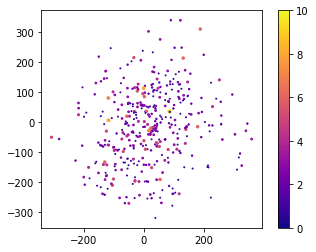

In [59]:
# Distribution of speaker positions relative to head

fig, ax = plt.subplots(1,1)
sc = ax.scatter(stim['h2s_x'], stim['h2s_y'], s=stim['SpikeCount'], c=stim['SpikeCount'], cmap=cm.plasma, vmin=0, vmax=10)
# sc = ax.scatter(stim['h2s_x'], stim['h2s_y'], s=stim['SpikeCount'])
ax.set_aspect(1)
plt.colorbar(sc)

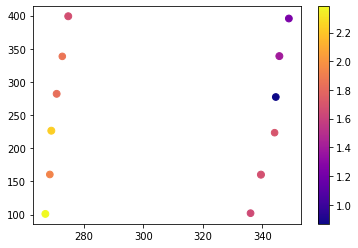

In [64]:
bySpk = stim.groupby(by='Speaker')

x = bySpk['speak_xpix'].unique().to_numpy()
y = bySpk['speak_ypix'].unique().to_numpy()
c = bySpk['SpikeCount'].mean()
n = bySpk['SpikeCount'].count()

fig, ax = plt.subplots(1,1)
sc = ax.scatter(x, y, s=n, c=c, cmap=cm.plasma)
# ax.set_aspect(1)
plt.colorbar(sc)

[[0.706178 0.178437 0.553657 1.      ]
 [0.992505 0.777967 0.152855 1.      ]
 [0.940015 0.975158 0.131326 1.      ]
 [0.979644 0.854866 0.142453 1.      ]
 [0.973416 0.585761 0.25154  1.      ]
 [0.983041 0.624131 0.227937 1.      ]
 [0.85975  0.360588 0.406917 1.      ]
 [0.977856 0.602051 0.241387 1.      ]
 [0.959424 0.543431 0.278701 1.      ]
 [0.752312 0.227133 0.513149 1.      ]
 [0.809052 0.293491 0.45887  1.      ]
 [0.636008 0.112092 0.605205 1.      ]]


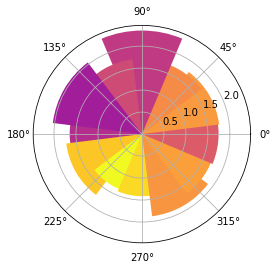

In [75]:
n_bins = 12
interval = (2 * np.pi) / n_bins

theta = np.linspace(-np.pi, np.pi-interval, n_bins)
rho, n = [], []


for val in theta:

    bin_data = stim[(stim['h2s_theta'] >= val) & (stim['h2s_theta'] < val + interval)]
    rho.append( bin_data['SpikeCount'].mean())
    n.append( bin_data['SpikeCount'].shape[0])

n = np.array(n) / max(n)
n = cm.plasma(n)
print(n)

ax = plt.subplot(projection='polar')
ax.bar(theta, rho, color=cm.plasmatn)
plt.show()

Now we get the vector from head to stimulus (h2s = "head to stimulus" or "head to speaker")

In [ ]:
hs_data['h2s_x'] = hs_data['speak_xpix'] - hs_data['head_x']
hs_data['h2s_y'] = hs_data['speak_ypix'] - hs_data['head_y']

hs_data['h2s_distance'] = np.sqrt((hs_data['h2s_y'] ** 2) +  (hs_data['h2s_x']**2))

hs_data['h2s_theta'] = np.arctan2(hs_data['h2s_y'], hs_data['h2s_x']) - hs_data['head_angle']
hs_data['h2s_theta'] = hs_data['h2s_theta'].apply(wrap_to_pi)

hs_data['h2s_x'] = hs_data['h2s_distance'] * np.cos(hs_data['h2s_theta'])  
hs_data['h2s_y'] = hs_data['h2s_distance'] * np.sin(hs_data['h2s_theta'])  

hs_data.head(n=3)


Finally we save the data for use with neural analysis

In [48]:
stim.columns

Index(['Unnamed: 0', 'index', 'Global_Idx', 'Block', 'Local_Idx', 'Speaker',
       'Pulse_Samp', 'Pulse_Time', 'EstimatedTimeOut', 'MCS_Time',
       'est_frame_time', 'closest_frame', 'frame', 'blue_x', 'red_x', 'blue_y',
       'red_y', 'head_x', 'head_y', 'blue_zero_x', 'blue_zero_y', 'head_angle',
       'speak_xpix', 'speak_ypix', 'h2s_x', 'h2s_y', 'h2s_distance',
       'h2s_theta', 'SpikeCount'],
      dtype='object')

## Visualization

### Fig. 1(A) - Annotated Frame

In [ ]:
# Draw an example
idx = 100

plt.rcParams['figure.figsize'] = [16, 6]
fig, axs = plt.subplots(1,1)

# Plot positions in image
axs[0].scatter(hs_data['head_x'][idx], hs_data['head_y'][idx],c='k')
axs[0].scatter(hs_data['blue_x'][idx], hs_data['blue_y'][idx],c='b')
axs[0].scatter(hs_data['red_x'][idx], hs_data['red_y'][idx],c='r')
axs[0].scatter(hs_data['speak_xpix'][idx], hs_data['speak_ypix'][idx],c='#009900')

axs[0].set_xlim(0, 640)
axs[0].set_ylim(0, 480)
axs[0].set_aspect(480/640)
axs[0].set_title(f'head angle = {hs_data.head_angle[idx]:.3f}\nhead-to-stim_angle:{hs_data.h2s_theta[idx]:.3f}\nDistance:{hs_data.h2s_distance[idx]:.1f}px')

# Plot in head-centred coordinates
def pol2cart(rho, theta):
    x = rho * np.cos(theta)  
    y = rho * np.sin(theta)  
    return (x, y)

spk_pos = pol2cart(hs_data['h2s_distance'][idx], hs_data['h2s_theta'][idx])


axs[1].scatter(hs_data['blue_zero_x'][idx], hs_data['blue_zero_y'][idx],c='b')
axs[1].scatter(hs_data['h2s_x'][idx], hs_data['h2s_y'][idx],c='#009900')

axs[1].plot([0, hs_data['h2s_x'][idx]], [0, hs_data['h2s_y'][idx]], c='#99FF99', linestyle='--')

# cmap = cm.get_cmap('RdYlBu')
# for phi in np.linspace(-np.pi, np.pi, 13):
#     x = rho * np.cos(phi)
#     y = rho * np.sin(phi)
#     c = (phi + np.pi) / (2 * np.pi)

#     axs[1].plot([0, x], [0, y], c=cmap(c), linestyle='--')
    # axs[1].text(x, y, f'{phi:.3f}')
    
# Plot vector along midline of head
rho = 10
x = rho * np.cos(hs_data['head_angle'][idx])  
y = rho * np.sin(hs_data['head_angle'][idx])  

axs[0].plot([0, x]+hs_data['head_x'][idx], [0, y]+hs_data['head_y'][idx], c='k', linewidth=2)
axs[1].plot([0, x], [0, y], c='k', linewidth=2)

axs[1].set_aspect('equal')
plt.show()

In [ ]:
# Distribution of speaker positions relative to head
fig, ax = plt.subplots(1,1)
ax.scatter(hs_data['h2s_x'], hs_data['h2s_y'], c=hs_data['Speaker'], cmap=cm.Accent)
ax.set_aspect(1)

In [ ]:
sample_frame = 4405
plt.rcParams['figure.figsize'] = [16, 12]

# Corrected frame
im_path = Path('/home/stephen/Github/Speaker_Grid/data/F1901_Crumble_Squid/2021-05-27_Squid_15-57/example_images_corrected/')
im_file = f"frame{sample_frame:06d}.png"

img = mpimg.imread(str(im_path / im_file))
imgplot = plt.imshow(img)

# LED positions obtained from corrected image
sample_data = join_data[join_data['closest_frame'] == sample_frame]
plt.scatter(sample_data['blue_x'],sample_data['blue_y'], s=1, edgecolors='#6FBAFC', facecolors='none')
plt.scatter(sample_data['red_x'],sample_data['red_y'], s=1, edgecolors='#FC6F6F', facecolors='none')

# Speaker positions from corrected image
speaker_layout = '/home/stephen/Github/Speaker_Grid/metadata/Speaker_grid_layout_2021_05_21.csv'

spk = pd.read_csv(speaker_layout)
spk.dropna(inplace=True)

plt.scatter(spk['2021_05_31_PixLoc_Corrected_x'],spk['2021_05_31_PixLoc_Corrected_y'],c='#FFF300', s=1)

# Label Speaker being played
active_speaker = pd.merge(sample_data, spk, left_on='Speaker', right_on='matlab_chan')

plt.scatter(active_speaker['2021_05_31_PixLoc_Corrected_x'], active_speaker['2021_05_31_PixLoc_Corrected_y'], edgecolors='#FFF388', s=100, facecolors='none')

In [ ]:
plt_window = (-40, 40)

# # Filter image with laplacian to make features visible
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray,(3,3),0)
# laplacian = cv2.Laplacian(gray, cv2.CV_64F)


# Replot everything from above, but with the intention of zooming in
zoom_plt = plt.imshow(img)
plt.scatter(sample_data['blue_x'],sample_data['blue_y'], s=1, edgecolors='#6FBAFC', facecolors='none')
plt.scatter(sample_data['red_x'],sample_data['red_y'], s=1, edgecolors='#FC6F6F', facecolors='none')
plt.scatter(spk['2021_05_31_PixLoc_Corrected_x'],spk['2021_05_31_PixLoc_Corrected_y'],c='#FFF300', s=1)

x_min = sample_data[['blue_x', 'red_x']].to_numpy().min() + plt_window[0]
x_max = sample_data[['blue_x', 'red_x']].to_numpy().max() + plt_window[1]
y_min = sample_data[['blue_y', 'red_y']].to_numpy().min() + plt_window[0]
y_max = sample_data[['blue_y', 'red_y']].to_numpy().max() + plt_window[1]

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


In [ ]:


active_speaker
